# Building maps

Features of this maps are:

- shapefile shape_field+2nearest_1 (200m x 200m area)
- ONLY VV POLARIZATION
- no cut on backscattering data (no filters for outliers)
- colorbar limits fixed at [+5,-25]
- rainbow colorbar with blue higher values and red lower values
- title with date and period

## Dependencies and support functions 

In [14]:
import os
import fiona
import geopandas as gpd
import pandas as pd
import numpy as np
# from maps_original import *
import datetime as dtt
import pandas as pd
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sfilter

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.interpolate import griddata
import scipy
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [15]:
def toDB(data):
    logdata = 10*np.log10(data)
    return logdata

def fromDB(logdata):
    data = 10.**(logdata/10.)
    return data

## Building data dataframe

In [16]:
window = '51x51' # options: 51x51, 201x201
SP17 = pd.read_csv(f'Elaborazioni\SP17\pixEx\pixEx_{window}_GRD_measurements.txt', header = 5, delimiter = "\t")
AU17 = pd.read_csv(f'Elaborazioni\AU17\pixEx\pixEx_{window}_GRD_measurements.txt', header = 5, delimiter = "\t")
SP20 = pd.read_csv(f'Elaborazioni\SP20\pixEx\pixEx_{window}_GRD_measurements.txt', header = 5, delimiter = "\t")

SP17['Period'] = SP17.shape[0]*['SP17']
AU17['Period'] = AU17.shape[0]*['AU17']
SP20['Period'] = SP20.shape[0]*['SP20']
data = SP17.append(AU17).append(SP20)

data['db_Sigma0_VH'] = data['Sigma0_VH'].apply(toDB)
data['db_Sigma0_VV'] = data['Sigma0_VV'].apply(toDB)

data['Time(HH_mm_ss)'] = pd.to_datetime(data['Time(HH_mm_ss)'], format = '%H:%M:%S').apply(lambda x: x.time())#.dt.round('min')
data['Date(yyyy-MM-dd)'] = pd.to_datetime(data['Date(yyyy-MM-dd)'], format = '%Y-%m-%d').apply(lambda x: x.date())
data['Datetime_UTC'] = data.apply(lambda r : dtt.datetime.combine(r['Date(yyyy-MM-dd)'],r['Time(HH_mm_ss)']),1).dt.round('min')
data['Date'] = data['Date(yyyy-MM-dd)']

loco17out1 = data.loc[(data['Datetime_UTC']<='2017-03-26 01:00:00')&(data['Datetime_UTC'].dt.year == 2017)]
loco17inn2 = data.loc[(data['Datetime_UTC']>='2017-03-26 01:00:00')&(data['Datetime_UTC']<='2017-10-29 01:00:00')]
loco17out3 = data.loc[(data['Datetime_UTC']>='2017-10-29 01:00:00')&(data['Datetime_UTC'].dt.year == 2017)]

loco20out1 = data.loc[(data['Datetime_UTC']<='2020-03-29 01:00:00')&(data['Datetime_UTC'].dt.year == 2020)]
loco20inn2 = data.loc[(data['Datetime_UTC']>='2020-03-29 01:00:00')&(data['Datetime_UTC']<='2020-10-25 01:00:00')]
loco20out3 = data.loc[(data['Datetime_UTC']>='2020-10-25 01:00:00')&(data['Datetime_UTC'].dt.year == 2020)]

aloco17out1 = loco17out1.copy() #empty
aloco17inn2 = loco17inn2.copy()
aloco17out3 = loco17out3.copy()
aloco20out1 = loco20out1.copy()
aloco20inn2 = loco20inn2.copy() #empty
aloco20out3 = loco20out3.copy() #empty

aloco17out1['Datetime_Budrio'] = loco17out1['Datetime_UTC']+pd.offsets.Hour(1)
aloco17inn2['Datetime_Budrio'] = loco17inn2['Datetime_UTC']+pd.offsets.Hour(2)
aloco17out3['Datetime_Budrio'] = loco17out3['Datetime_UTC']+pd.offsets.Hour(1)
aloco20out1['Datetime_Budrio'] = loco20out1['Datetime_UTC']+pd.offsets.Hour(1)
aloco20inn2['Datetime_Budrio'] = loco20inn2['Datetime_UTC']+pd.offsets.Hour(2)
aloco20out3['Datetime_Budrio'] = loco20out3['Datetime_UTC']+pd.offsets.Hour(1)

data17 = aloco17out1.append(aloco17inn2).append(aloco17out3)
data20 = aloco20out1.append(aloco20inn2).append(aloco20out3)
data = data17.append(data20)

data['ID'] = data.index
data['Code'] = data['Period'] 
data = data.drop(['CoordID','Name','ProdID'], axis = 1) #'projectedLocalIncidenceAngle','incidenceAngleFromEllipsoid'
data = data.set_index(['Period','Date(yyyy-MM-dd)'])

C:\Users\MARTINA\AppData\Local\Temp\ipykernel_17304\1532213204.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = SP17.append(AU17).append(SP20)
C:\Users\MARTINA\AppData\Local\Temp\ipykernel_17304\1532213204.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data17 = aloco17out1.append(aloco17inn2).append(aloco17out3)
C:\Users\MARTINA\AppData\Local\Temp\ipykernel_17304\1532213204.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data17 = aloco17out1.append(aloco17inn2).append(aloco17out3)
C:\Users\MARTINA\AppData\Local\Temp\ipykernel_17304\1532213204.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data20 = aloco20out1.

In [17]:
data.head()

Latitude  Longitude  PixelX  PixelY Time(HH_mm_ss)  \
Period Date(yyyy-MM-dd)                                                        
SP17   2017-04-04        44.572931  11.529610   169.5   151.5       05:27:23   
       2017-04-04        44.572928  11.529736   170.5   151.5       05:27:23   
       2017-04-04        44.572925  11.529862   171.5   151.5       05:27:23   
       2017-04-04        44.572922  11.529988   172.5   151.5       05:27:23   
       2017-04-04        44.572920  11.530113   173.5   151.5       05:27:23   

                         Sigma0_VH  Sigma0_VV   latitude  longitude  \
Period Date(yyyy-MM-dd)                                               
SP17   2017-04-04         0.009288   0.037626  44.572929  11.529610   
       2017-04-04         0.007629   0.072989  44.572929  11.529736   
       2017-04-04         0.005863   0.112742  44.572926  11.529861   
       2017-04-04         0.005478   0.121640  44.572922  11.529987   
       2017-04-04         0.004999   0.123163  44.572918  11.530113   

                         localIncidenceAngle  projectedLocalIncidenceAngle  \
Period Date(yyyy-MM-dd)                                                      
SP17   2017-04-04                  32.128319                     32.127899   
       2017-04-04                  32.147514                     32.147419   
       2017-04-04                  32.166943                     32.166943   
       2017-04-04                  32.380600                     32.380478   
       2017-04-04                  32.623951                     32.623379   

                         incidenceAngleFromEllipsoid  db_Sigma0_VH  \
Period Date(yyyy-MM-dd)                                              
SP17   2017-04-04                          31.739079    -20.320928   
       2017-04-04                          31.738386    -21.175399   
       2017-04-04                          31.737694    -22.319108   
       2017-04-04                          31.737003    -22.614121   
       2017-04-04                          31.736303    -23.010787   

                         db_Sigma0_VV        Datetime_UTC        Date  \
Period Date(yyyy-MM-dd)                                                 
SP17   2017-04-04          -14.245149 2017-04-04 05:27:00  2017-04-04   
       2017-04-04          -11.367416 2017-04-04 05:27:00  2017-04-04   
       2017-04-04           -9.479141 2017-04-04 05:27:00  2017-04-04   
       2017-04-04           -9.149234 2017-04-04 05:27:00  2017-04-04   
       2017-04-04           -9.095213 2017-04-04 05:27:00  2017-04-04   

                            Datetime_Budrio  ID  Code  
Period Date(yyyy-MM-dd)                                
SP17   2017-04-04       2017-04-04 07:27:00   0  SP17  
       2017-04-04       2017-04-04 07:27:00   1  SP17  
       2017-04-04       2017-04-04 07:27:00   2  SP17  
       2017-04-04       2017-04-04 07:27:00   3  SP17  
       2017-04-04       2017-04-04 07:27:00   4  SP17

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 153459 entries, ('SP17', datetime.date(2017, 4, 4)) to ('SP20', datetime.date(2020, 3, 21))
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Latitude                      153459 non-null  float64       
 1   Longitude                     153459 non-null  float64       
 2   PixelX                        153459 non-null  float64       
 3   PixelY                        153459 non-null  float64       
 4   Time(HH_mm_ss)                153459 non-null  object        
 5   Sigma0_VH                     153459 non-null  float64       
 6   Sigma0_VV                     153459 non-null  float64       
 7   latitude                      153459 non-null  float64       
 8   longitude                     153459 non-null  float64       
 9   localIncidenceAngle           153459 non-null  float64       
 10  projectedLocalIn

## Building georeferenced dataframe

In [19]:
gdata = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
gdata.head()

Latitude  Longitude  PixelX  PixelY Time(HH_mm_ss)  \
Period Date(yyyy-MM-dd)                                                        
SP17   2017-04-04        44.572931  11.529610   169.5   151.5       05:27:23   
       2017-04-04        44.572928  11.529736   170.5   151.5       05:27:23   
       2017-04-04        44.572925  11.529862   171.5   151.5       05:27:23   
       2017-04-04        44.572922  11.529988   172.5   151.5       05:27:23   
       2017-04-04        44.572920  11.530113   173.5   151.5       05:27:23   

                         Sigma0_VH  Sigma0_VV   latitude  longitude  \
Period Date(yyyy-MM-dd)                                               
SP17   2017-04-04         0.009288   0.037626  44.572929  11.529610   
       2017-04-04         0.007629   0.072989  44.572929  11.529736   
       2017-04-04         0.005863   0.112742  44.572926  11.529861   
       2017-04-04         0.005478   0.121640  44.572922  11.529987   
       2017-04-04         0.004999   0.123163  44.572918  11.530113   

                         localIncidenceAngle  projectedLocalIncidenceAngle  \
Period Date(yyyy-MM-dd)                                                      
SP17   2017-04-04                  32.128319                     32.127899   
       2017-04-04                  32.147514                     32.147419   
       2017-04-04                  32.166943                     32.166943   
       2017-04-04                  32.380600                     32.380478   
       2017-04-04                  32.623951                     32.623379   

                         incidenceAngleFromEllipsoid  db_Sigma0_VH  \
Period Date(yyyy-MM-dd)                                              
SP17   2017-04-04                          31.739079    -20.320928   
       2017-04-04                          31.738386    -21.175399   
       2017-04-04                          31.737694    -22.319108   
       2017-04-04                          31.737003    -22.614121   
       2017-04-04                          31.736303    -23.010787   

                         db_Sigma0_VV        Datetime_UTC        Date  \
Period Date(yyyy-MM-dd)                                                 
SP17   2017-04-04          -14.245149 2017-04-04 05:27:00  2017-04-04   
       2017-04-04          -11.367416 2017-04-04 05:27:00  2017-04-04   
       2017-04-04           -9.479141 2017-04-04 05:27:00  2017-04-04   
       2017-04-04           -9.149234 2017-04-04 05:27:00  2017-04-04   
       2017-04-04           -9.095213 2017-04-04 05:27:00  2017-04-04   

                            Datetime_Budrio  ID  Code  \
Period Date(yyyy-MM-dd)                                 
SP17   2017-04-04       2017-04-04 07:27:00   0  SP17   
       2017-04-04       2017-04-04 07:27:00   1  SP17   
       2017-04-04       2017-04-04 07:27:00   2  SP17   
       2017-04-04       2017-04-04 07:27:00   3  SP17   
       2017-04-04       2017-04-04 07:27:00   4  SP17   

                                          geometry  
Period Date(yyyy-MM-dd)                             
SP17   2017-04-04        POINT (11.52961 44.57293)  
       2017-04-04        POINT (11.52974 44.57293)  
       2017-04-04        POINT (11.52986 44.57292)  
       2017-04-04        POINT (11.52999 44.57292)  
       2017-04-04        POINT (11.53011 44.57292)

In [20]:
# Print available shapefiles
[files for root, dirs, files in os.walk('Shapefiles')]

[['budrio.finale.placemark',
  'subset_20x20.kml',
  'traliccio.kml',
  'traliccio.kmz',
  'traliccio.placemark',
  'intorno_traliccio_cerchio_10m.kmz',
  'intorno_traliccio_cerchio_10m.kml',
  'intorno_traliccio_quadrato_20m.kml',
  'Budrio_campo_safe.kml',
  'Budrio_campo_safe_half.kml',
  'Budrio_campo_right.kml',
  'Budrio_traliccio_base_safe.kml',
  'subset_2_600x600.kmz',
  'subset_2_600x600.kml',
  'quadrato_800m.kmz',
  'quadrato_800m.kml',
  'shape_traliccio_nord.kml',
  'shape_traliccio_sud.kml',
  'traliccio_sud.kml',
  'traliccio_nord.kml',
  'traliccio_sud.txt',
  'traliccio_nord.txt',
  'traliccio_nord.placemark',
  'traliccio_sud.placemark',
  'case_calib.kml',
  'Stazione_gamma.kmz',
  'Visione_gamma.kmz',
  'fields_main_right.kml'],
 ['Budrio_campo_safe-checkpoint.kml']]

In [21]:
# Enable the read and write functionalities for KML-driver
# gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' # deprecated
# fiona.supported_drivers
fiona.drvsupport.supported_drivers['KML'] = 'rw'

# Filepath to KML file
fp = "Shapefiles/subset_20x20.kml" # 200 m x 200 m

# Import into a geoDataFrame
pr_regions = gpd.read_file(fp, driver='KML')
# pr_regions['geometry']

# vertices of the polygon
# 11.53202281576129,44.57005269861398,0
# 11.53233753426577,44.56994856183717,0
# 11.5329550345901,44.57073814681876,0
# 11.53263132024715,44.57084320694042,0

In [22]:
#identify those records from gdf that are intersecting with the region polygon
#this action will return a series with boolean values, if value is True it means the point 
#in that index location is within the polygon we are evaluating

pip = gdata.within(pr_regions.loc[0, 'geometry'])
#pip = ~gdata.within(pr_regions.loc[0, 'geometry']) #this returns all the points OUTSIDE the selected region

#creating a new gdf keep only the intersecting records
gdata_subset = gdata[pip].copy()

#assign region name
gdata_subset['region'] = 'quadrato_200' # 'quadrato_800'

gdata_subset.head()
gdata_subset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 24503 entries, ('SP17', datetime.date(2017, 4, 4)) to ('SP20', datetime.date(2020, 3, 21))
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Latitude                      24503 non-null  float64       
 1   Longitude                     24503 non-null  float64       
 2   PixelX                        24503 non-null  float64       
 3   PixelY                        24503 non-null  float64       
 4   Time(HH_mm_ss)                24503 non-null  object        
 5   Sigma0_VH                     24503 non-null  float64       
 6   Sigma0_VV                     24503 non-null  float64       
 7   latitude                      24503 non-null  float64       
 8   longitude                     24503 non-null  float64       
 9   localIncidenceAngle           24503 non-null  float64       
 10  projectedLocalInciden

In [23]:
# draw_map version with additional passed parameters that will be written in the title:
# label = date
# period = periodo
# colorbar is "Spectral", a rainbow colorbar that means that lower backscattering values are in blue and higher are in red. To obtain the inverse result (higher in red, lower in blue) you have to redefine cmap = 'Spectral_r' meaning Spectral_reversed

def draw_map(lat_list, lon_list, value_list, pol, label, period , z_min = -999, z_max = -999, n_levels = -999, map_type='satellite', mesh_type='contourf', zoom = 15, save = False, ax = None, trajectory = False, log = None, fig = None, fileNAME = 'Map'):

    if n_levels == -999:
        n_levels = 10

    if z_min == -999:
        z_min = min(value_list)

    if z_max == -999:
        z_max = max(value_list)

    center_lon = np.asarray(lon_list).mean()
    center_lat = np.asarray(lat_list).mean()
    width = 1.1*max([max(lon_list)-min(lon_list), max(lat_list)-min(lat_list)])
    lon_min = center_lon-0.5*width
    lon_max = center_lon+0.5*width
    lat_min = center_lat-0.5*width
    lat_max = center_lat+0.5*width

    if map_type=='satellite':
        url = 'http://mt0.google.com/vt/lyrs=s&hl=en&x={x}&y={y}&z={z}'
    elif map_type=='map':
        url = 'http://mt0.google.com/vt/lyrs=m&hl=en&x={x}&y={y}&z={z} '

    stamen_terrain = cimgt.GoogleTiles(url = url)#cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    if ax == None:
        if fig == None:
            fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)
        ax.set_aspect('equal')

    # gl = ax.gridlines(draw_labels=True, alpha=0.3, ls = ':', color = 'k')
    # gl.xlabels_top = gl.ylabels_right = False
    # gl.xformatter = LONGITUDE_FORMATTER
    # gl.yformatter = LATITUDE_FORMATTER
    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, zoom)


    lon_arr          = np.linspace(min(lon_list), max(lon_list), 500)
    lat_arr          = np.linspace(min(lat_list), max(lat_list), 500)
    lon_mesh, lat_mesh = np.meshgrid(lon_arr, lat_arr)
    MMGC_mesh = griddata((np.asarray(lon_list), np.asarray(lat_list)), np.asarray(value_list), (lon_mesh, lat_mesh), method='nearest')
    
    sigma = [5, 5]
    #sigma = [10, 10]
    #sigma = [0, 0]
#     MMGC_mesh = scipy.ndimage.filters.gaussian_filter(MMGC_mesh, sigma, mode='constant')
# more filters on scipy.ndimage site

    x, y = lon_mesh, lat_mesh
    cmap = mplt.cm.get_cmap('Spectral')
    
    if mesh_type=='contourf':
        ax.contourf(x, y, MMGC_mesh, alpha=0.8, cmap=cmap, linestyles='None', vmin=z_min, vmax=z_max, levels = n_levels, transform=ccrs.PlateCarree())
        mesh = ax.contourf([x.min(), x.max()], [y.min(), y.max()], [[z_min, z_max],[z_min, z_max]], alpha=1, cmap=cmpa, linestyles='None', vmin=z_min, vmax=z_max, levels = n_levels, zorder = -5, transform=ccrs.PlateCarree())
    elif mesh_type=='mesh':
        ax.pcolormesh(x, y, MMGC_mesh, shading='nearest',cmap=cmap, vmin=z_min, vmax=z_max, alpha=0.7, transform=ccrs.PlateCarree())
        mesh = ax.pcolormesh(x, y, MMGC_mesh, shading='nearest', cmap=cmap, vmin=z_min, vmax=z_max, alpha=1, zorder = -5, transform=ccrs.PlateCarree())

    if trajectory:
        try:
            ax.plot(log['Lng'], log['Lat'], transform=ccrs.PlateCarree(), c  = 'k')
        except:
            raise Exception('Log not provided!')

    #plt.scatter(x_orig, y_orig, s=5*data[' Absolute Altitude (m)']+1, c='k')
    #fig.colorbar(contourf, boundaries=np.linspace(vmin, vmax, n_levels))
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    # gl.xlines = True
    # gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
    # gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'rotation': 25, 'ha':'right'}
    gl.ylabel_style = {'rotation': 25, 'ha':'right'}
    #gl.xlabel_style = {'rotation': 45}
    #gl.ylabel_style = {'rotation': 45}
    # gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
    #ax.scatter(lon_list, lat_list, c = value_list, transform=ccrs.PlateCarree(), zorder = 20, s = 100, cmap='Spectral_r', vmin=vmin, vmax=vmax)

    fig.colorbar(mesh, label = '$\sigma^0$ [dB]')
    fig.tight_layout()
    #fig.suptitle('Provetta', fontsize = 16)
    titletime = label.strftime("%Y-%m-%d %H:%M")
    ax.set_title(f'[{pol}] {period} {titletime}', fontsize = 16)
    if save:
        #current_time = label.strftime("%Y-%m-%d_%H-%M")
        #fileNAME = f'Out_maps//DataVV_nocut//{period}//{period}_{current_time}_VV.png'
        fig.savefig(fileNAME, bbox_inches = 'tight',pad_inches = 0.3)
        plt.close()
        ax.clear()
        return fileNAME

### Plot 1 day to check if it alright

C:\Anaconda3\envs\satellite\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


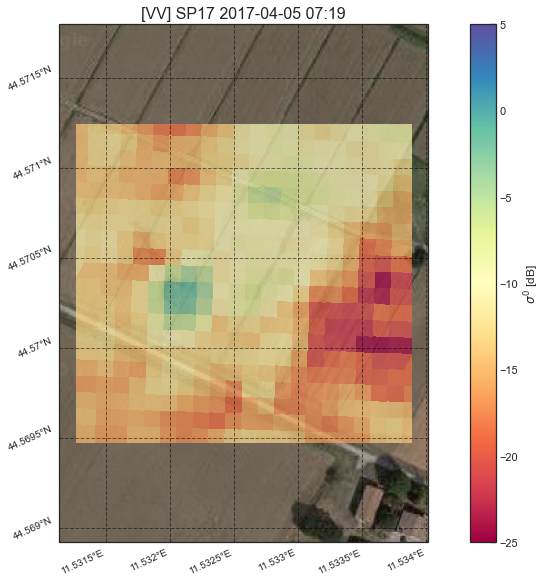

In [26]:
ggiorno = gdata_subset.loc[gdata_subset['Date']==pd.to_datetime('2017-04-05')]
#ggiorno = gdata.loc[gdata['Date']==pd.to_datetime('2017-04-05')]

label = ggiorno['Datetime_Budrio'][0]
period = ggiorno['Code'][0]
#period = 'MAP'
# pol = 'VV'
pol = 'VV'

if pol == 'VV':
    z_min = -25
    z_max = 5
elif pol == 'VH':
    z_min = -40
    z_max = -5
else:
    raise NameError('Please provide VV or VH as polarizations, as string objects.')

draw_map(ggiorno.Latitude, ggiorno.Longitude, ggiorno.db_Sigma0_VV, pol, label, period, z_min=z_min, z_max=z_max,
         map_type='satellite', mesh_type='mesh', zoom=17,
         save=False, ax=None, trajectory=False, log=None, fig=None)

In [25]:
gdata_subset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 24503 entries, ('SP17', datetime.date(2017, 4, 4)) to ('SP20', datetime.date(2020, 3, 21))
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Latitude                      24503 non-null  float64       
 1   Longitude                     24503 non-null  float64       
 2   PixelX                        24503 non-null  float64       
 3   PixelY                        24503 non-null  float64       
 4   Time(HH_mm_ss)                24503 non-null  object        
 5   Sigma0_VH                     24503 non-null  float64       
 6   Sigma0_VV                     24503 non-null  float64       
 7   latitude                      24503 non-null  float64       
 8   longitude                     24503 non-null  float64       
 9   localIncidenceAngle           24503 non-null  float64       
 10  projectedLocalInciden